In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import sympy as sym
import warnings

from IPython.display import display, Math
from numpy.lib.scimath import sqrt as csqrt
from scipy.constants import c
from scipy.constants import value
from numpy.random import normal

from optic.dsp import firFilter, pulseShape,  lowPassFIR
from optic.models import mzm
from optic.plot import eyediagram
from commpy.utilities  import signal_power, upsample

## Funções

In [50]:
def supergauss(t,T0,C,m):
    return np.exp( -1*(1+1j*C)/2 * (t/T0)**(2*m))



def SSF_symmetric(E, hz, Lspan, alpha, gamma, D, Fc, Fs):
    λ  = c/Fc
    α  = 1e-3*alpha/(10*np.log10(np.exp(1)))
    β2 = -(D*λ**2)/(2*np.pi*c)

    Nfft = len(E)

    ω = 2*np.pi*Fs*np.fft.fftfreq(Nfft)
    z = 0

    E = np.fft.fft(E)

    while z <= Lspan:
        # Primeiro passo - operador linear
        E = E*np.exp(-α*(hz/2)+1j*(β2/2)*(ω**2)*(hz/2))

        # Operador não linear
        E = np.fft.ifft(E)
        E = E*np.exp(1j*gamma*(np.abs(E)**2)*hz)

        # Segundo passo - operador linear
        E = np.fft.fft(E)
        E = E*np.exp(-α*(hz/2)+1j*(β2/2)*(ω**2)*(hz/2))

        z += hz

    E = np.fft.ifft(E)
    return E,z

# Análise Super-Gaussiano sem dispersão

### Pulso Super-Gaussiano
$$ A(t) = e^{-\frac{1}{2}(\frac{t}{T_{0}})^{2m}} \cdot e^{-jC\frac{1}{2}(\frac{t}{T_{0}})^{2m}} = e^{-\frac{1+jC}{2}(\frac{t}{T_{0}})^{2m}}$$

In [51]:
# parâmetros da simulação
SpS = 32
Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem
lmbd   = 1550e-9       # comprimento de onda
Pi_dBm = -10           # potência de sinal óptico na entrada do modulador em dBm
StepF  = 500          # Passo da Split-Step Fourier (m)

# Parâmetros do MZM
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# Parâmetros da fibra
#D = 18e-6                        # Parâmetro de dispersão ps/(nm*km) - SMF28
D = 0  
beta2 = -(D*lmbd**2)/(2*np.pi*c) # GVD
z = 15e3                         # Comprimento do enlace
alpha = 0.2                      # Coeficiente de perdas dB/Km
gamma = 2*1.3e-3                   # Coeficiente Não-linear W-1/m

# Parâmetros do receptor
Rd  = 0.85      # responsividade em A/W

if(beta2==0):
    display(Math('Comprimento~de~dispersão = \\inf ~~~~~~~~~~~~~~ \\beta_{2} = %5.8f\cdot10^{-24}' %(beta2*1e24)))
else:
    LD = (Ts**2)/abs(beta2)
    display(Math('Comprimento~de~dispersão = %5.2f~m ~~~~~~~~~~~~~~ \\beta_{2} = %5.8f\cdot10^{-24}' %(LD,beta2*1e24)))

<IPython.core.display.Math object>

## Análise dos efeitos no pulso

<IPython.core.display.Math object>

<IPython.core.display.Math object>

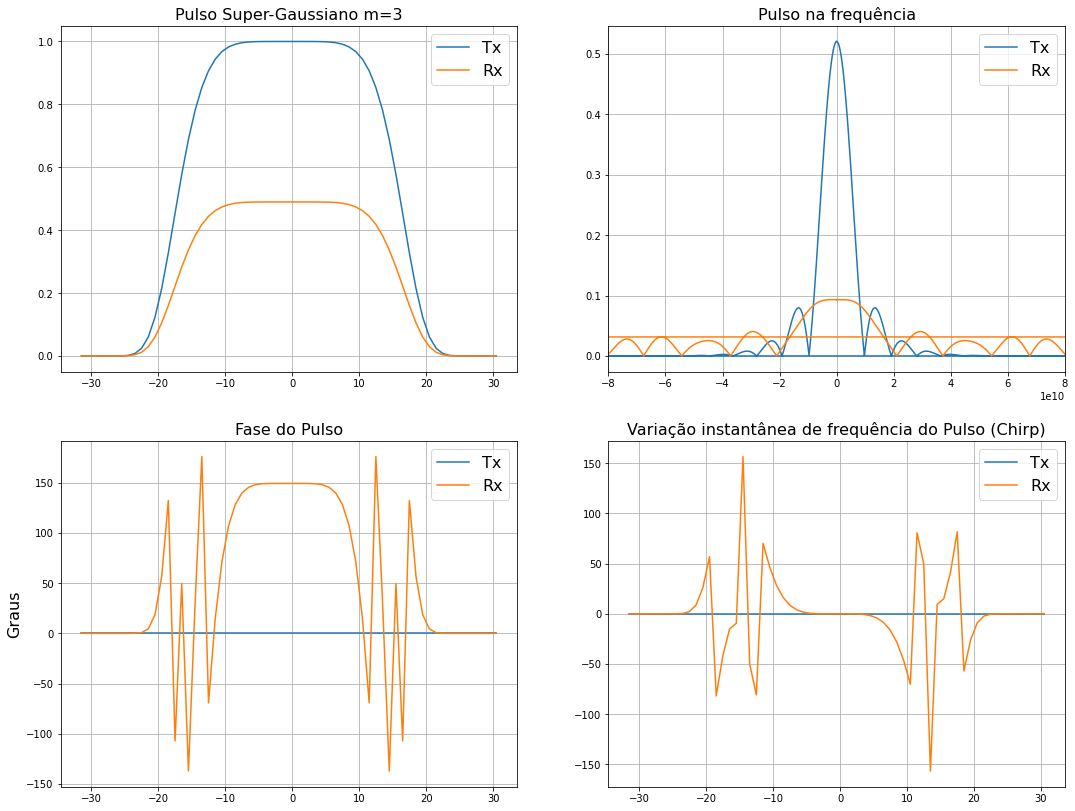

In [52]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bits-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

SpSSize = 2*SpS-1
xArray = np.arange(0,SpSSize,1)
preSsf = supergauss(xArray-(SpSSize/2)+0.5, SpSSize/4, 0, 3).real
posSsf, lent = SSF_symmetric(preSsf, StepF, z, alpha, gamma, D, c/lmbd, Fa) # Função de transferência do canal sem dispersão

# formatação de pulso
sigTx  = firFilter(preSsf.real, symbolsUp)

figure, ax = plt.subplots(2,2,figsize=(18,14))
ax[0][0].plot(np.arange(-len(preSsf)/2,len(preSsf)/2,1),np.abs(preSsf),label='Tx')
ax[0][0].plot(np.arange(-len(posSsf)/2,len(posSsf)/2,1),np.abs(posSsf),label='Rx')
ax[0][0].set_title("Pulso Super-Gaussiano m=3",fontsize=16)
ax[0][0].legend(fontsize=16)
ax[0][0].grid(True)

fftSize = 2**12 # FFT Size
freq = np.fft.fftfreq(fftSize)*Fa

ax[0][1].plot(freq,np.abs(np.fft.fft(np.real(preSsf),fftSize))/len(xArray),label='Tx')
ax[0][1].plot(freq,np.abs(np.fft.fft(np.real(posSsf),fftSize))/len(xArray),label='Rx')
ax[0][1].set_title("Pulso na frequência",fontsize=16)
ax[0][1].legend(fontsize=16)
ax[0][1].grid(True)
ax[0][1].set_xlim(-Fa/4,Fa/4)

ax[1][0].plot(np.arange(-len(preSsf)/2,len(preSsf)/2,1),180/np.pi*np.angle(preSsf),label='Tx')
ax[1][0].plot(np.arange(-len(posSsf)/2,len(posSsf)/2,1),180/np.pi*np.angle(posSsf),label='Rx')
ax[1][0].set_title("Fase do Pulso",fontsize=16)
ax[1][0].set_ylabel("Graus",fontsize=16)
ax[1][0].legend(fontsize=16)
ax[1][0].grid(True)

ax[1][1].plot(np.arange(-len(preSsf)/2,len(preSsf)/2,1),np.gradient(180/np.pi*np.angle(preSsf),1),label='Tx')
ax[1][1].plot(np.arange(-len(posSsf)/2,len(posSsf)/2,1),np.gradient(180/np.pi*np.angle(posSsf),1),label='Rx')
ax[1][1].set_title("Variação instantânea de frequência do Pulso (Chirp)",fontsize=16)
ax[1][1].legend(fontsize=16)
ax[1][1].grid(True)

display(Math('Comprimento~do~enlace = %5.0f~km ~~~~~~~~~~~ \\alpha = %5.3f~dB/Km ~~~~~~~~~~~ \\gamma = %5.5f~W^{-1}/m'  %(z*1e-3,alpha,gamma)))
display(Math('Dispersão~da~fibra = %5.0f \cdot 10^{-6}~ps/(nm \cdot km) ~~~~~~~~~~~ Passo~SSF = %5.0f~m'  %(D,StepF)))

## Análise para potência reduzida

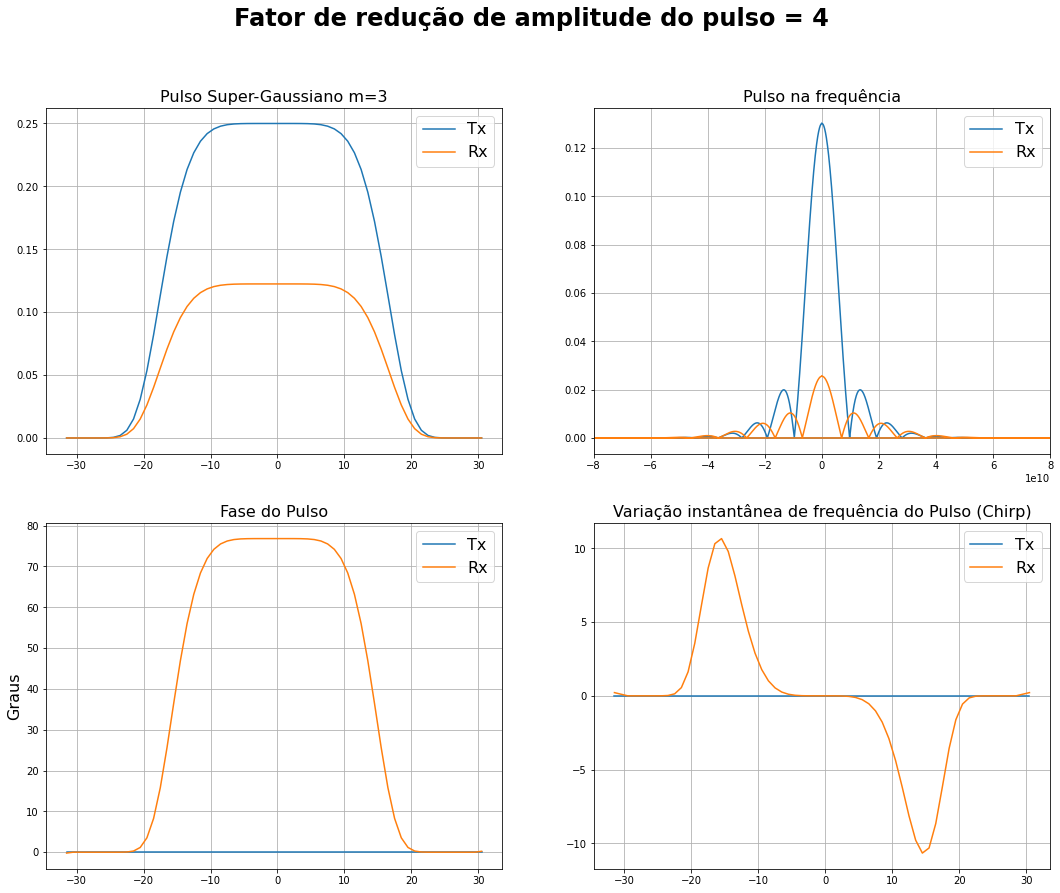

In [53]:
LowFac = 4 # Fator de redução de amplitude do pulso

LowpreSsf = (supergauss(xArray-(SpSSize/2)+0.5, SpSSize/4, 0, 3).real)/LowFac
LowposSsf, lent = SSF_symmetric(LowpreSsf, StepF, z, alpha, gamma, D, c/lmbd, Fa) # Função de transferência do canal sem dispersão


figure, ax = plt.subplots(2,2,figsize=(18,14))
figure.suptitle(f"Fator de redução de amplitude do pulso = {LowFac}", fontsize=24, fontweight="bold")

ax[0][0].plot(np.arange(-len(LowpreSsf)/2,len(LowpreSsf)/2,1),np.abs(LowpreSsf),label='Tx')
ax[0][0].plot(np.arange(-len(LowposSsf)/2,len(LowposSsf)/2,1),np.abs(LowposSsf),label='Rx')
ax[0][0].set_title("Pulso Super-Gaussiano m=3",fontsize=16)
ax[0][0].legend(fontsize=16)
ax[0][0].grid(True)

fftSize = 2**12 # FFT Size
freq = np.fft.fftfreq(fftSize)*Fa

ax[0][1].plot(freq,np.abs(np.fft.fft(np.real(LowpreSsf),fftSize))/len(xArray),label='Tx')
ax[0][1].plot(freq,np.abs(np.fft.fft(np.real(LowposSsf),fftSize))/len(xArray),label='Rx')
ax[0][1].set_title("Pulso na frequência",fontsize=16)
ax[0][1].legend(fontsize=16)
ax[0][1].grid(True)
ax[0][1].set_xlim(-Fa/4,Fa/4)

ax[1][0].plot(np.arange(-len(LowpreSsf)/2,len(LowpreSsf)/2,1),180/np.pi*np.angle(LowpreSsf),label='Tx')
ax[1][0].plot(np.arange(-len(LowposSsf)/2,len(LowposSsf)/2,1),180/np.pi*np.angle(LowposSsf),label='Rx')
ax[1][0].set_title("Fase do Pulso",fontsize=16)
ax[1][0].set_ylabel("Graus",fontsize=16)
ax[1][0].legend(fontsize=16)
ax[1][0].grid(True)

ax[1][1].plot(np.arange(-len(LowpreSsf)/2,len(LowpreSsf)/2,1),np.gradient(180/np.pi*np.angle(LowpreSsf),1),label='Tx')
ax[1][1].plot(np.arange(-len(LowposSsf)/2,len(LowposSsf)/2,1),np.gradient(180/np.pi*np.angle(LowposSsf),1),label='Rx')
ax[1][1].set_title("Variação instantânea de frequência do Pulso (Chirp)",fontsize=16)
ax[1][1].legend(fontsize=16)
ax[1][1].grid(True)

## Análise dos efeitos no receptor

In [54]:
# modulação óptica
Ai = np.sqrt(Pi)*np.ones(np.size(sigTx))
sigTxo = mzm(Ai, sigTx, Vπ, Vb)

# transmissão óptica
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))

# Fibra óptica
sigRxo, lent = SSF_symmetric(sigTxo, StepF, z, alpha, gamma, 0, c/lmbd, Fa) # Função de transferência do canal sem dispersão

alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
sigRxoAmp    = sigRxo*np.exp(alpha_lin * lent)                              # Amplification

sigRxoFFT = np.fft.fftshift(np.fft.fft(sigRxo))/NFFT
sigRxoPx  = np.abs(sigRxoFFT)**2
sigRxoFFTAmp = np.fft.fftshift(np.fft.fft(sigRxoAmp))/NFFT
sigRxoPxAmp  = np.abs(sigRxoFFTAmp)**2

Potência do sinal (em dBm) = -13.08 dBm


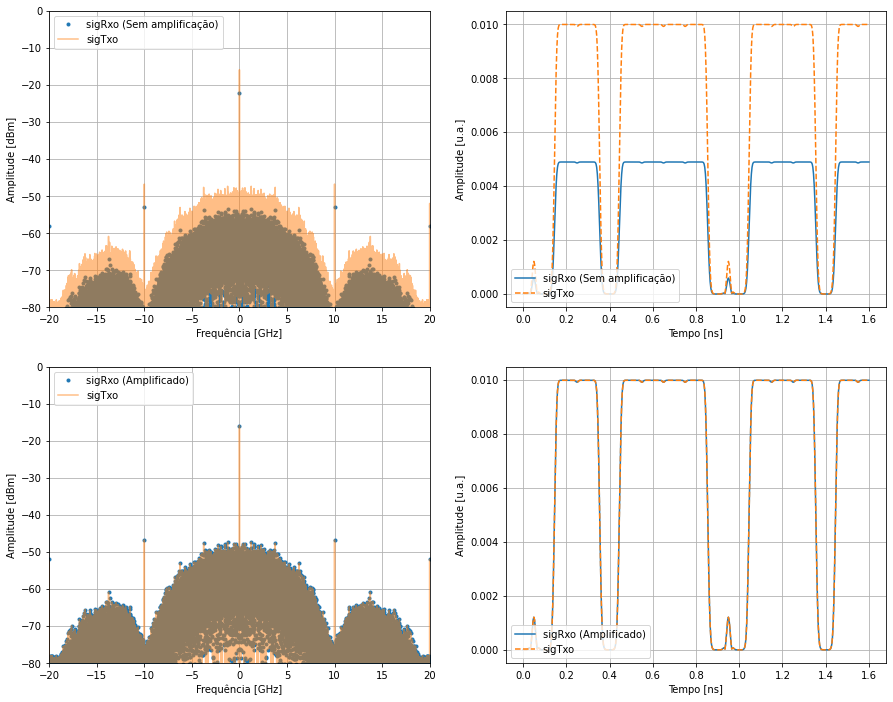

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(15,12))
axs[0][0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo (Sem amplificação)')
axs[0][0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0][0].set_ylabel('Amplitude [dBm]')
axs[0][0].set_xlabel('Frequência [GHz]')
axs[0][0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[0][0].set_ylim(-80,0)
axs[0][0].grid(True)
axs[0][0].legend(loc = 'upper left')

axs[0][1].plot(t[0:513], abs(sigRxo[0:513]), label = 'sigRxo (Sem amplificação)')
axs[0][1].plot(t[0:513], abs(sigTxo[0:513]), label = 'sigTxo', linestyle='--')
axs[0][1].set_xlabel('Tempo [ns]')
axs[0][1].set_ylabel('Amplitude [u.a.]')
axs[0][1].grid(True)
axs[0][1].legend(loc = 'lower left')

axs[1][0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPxAmp), '.', label = 'sigRxo (Amplificado)')
axs[1][0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[1][0].set_ylabel('Amplitude [dBm]')
axs[1][0].set_xlabel('Frequência [GHz]')
axs[1][0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[1][0].set_ylim(-80,0)
axs[1][0].grid(True)
axs[1][0].legend(loc = 'upper left')

axs[1][1].plot(t[0:513], abs(sigRxoAmp[0:513]), label = 'sigRxo (Amplificado)')
axs[1][1].plot(t[0:513], abs(sigTxo[0:513]), label = 'sigTxo', linestyle='--')
axs[1][1].set_xlabel('Tempo [ns]')
axs[1][1].set_ylabel('Amplitude [u.a.]')
axs[1][1].grid(True)
axs[1][1].legend(loc = 'lower left')

print('Potência do sinal (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigTxoPx)/1e-3)))

# Recepção do sinal óptico
Nsamples = 2**12

# fotocorrente livre de ruído
Ip   = Rd*np.abs(sigTxo)**2
I_Rx = Rd*np.abs(sigRxoAmp)**2

# Gaussiana em enlace de 4000 km

In [56]:
# parâmetros da simulação
SpS = 32
Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem
lmbd   = 1550e-9       # comprimento de onda
StepF  = 100           # Passo da Split-Step Fourier (m)

# Parâmetros do MZM
Vπ = 2
Vb = -Vπ/2

# Parâmetros da fibra
D = 18e-6                        # Parâmetro de dispersão ps/(nm*km) - SMF28  
beta2 = -(D*lmbd**2)/(2*np.pi*c) # GVD
z = 4000e3                         # Comprimento do enlace
alpha = 0.2                      # Coeficiente de perdas dB/Km
gamma = 1.3e-3                   # Coeficiente Não-linear W-1/m

# Parâmetros do receptor
Rd  = 0.85      # responsividade em A/W

if(beta2==0):
    display(Math('Comprimento~de~dispersão = \\inf ~~~~~~~~~~~~~~ \\beta_{2} = %5.8f\cdot10^{-24}' %(beta2*1e24)))
else:
    LD = (Ts**2)/abs(beta2)
    display(Math('Comprimento~de~dispersão = %5.2f~m ~~~~~~~~~~~~~~ \\beta_{2} = %5.8f\cdot10^{-24}' %(LD,beta2*1e24)))

display(Math('Comprimento~do~enlace = %5.0f~km ~~~~~~~~~~~ \\alpha = %5.3f~dB/Km ~~~~~~~~~~~ \\gamma = %5.5f~W^{-1}/m'  %(z*1e-3,alpha,gamma)))
display(Math('Dispersão~da~fibra = %5.0f \cdot 10^{-6}~ps/(nm \cdot km) ~~~~~~~~~~~ Passo~SSF = %5.0f~m'  %(D*1e6,StepF)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

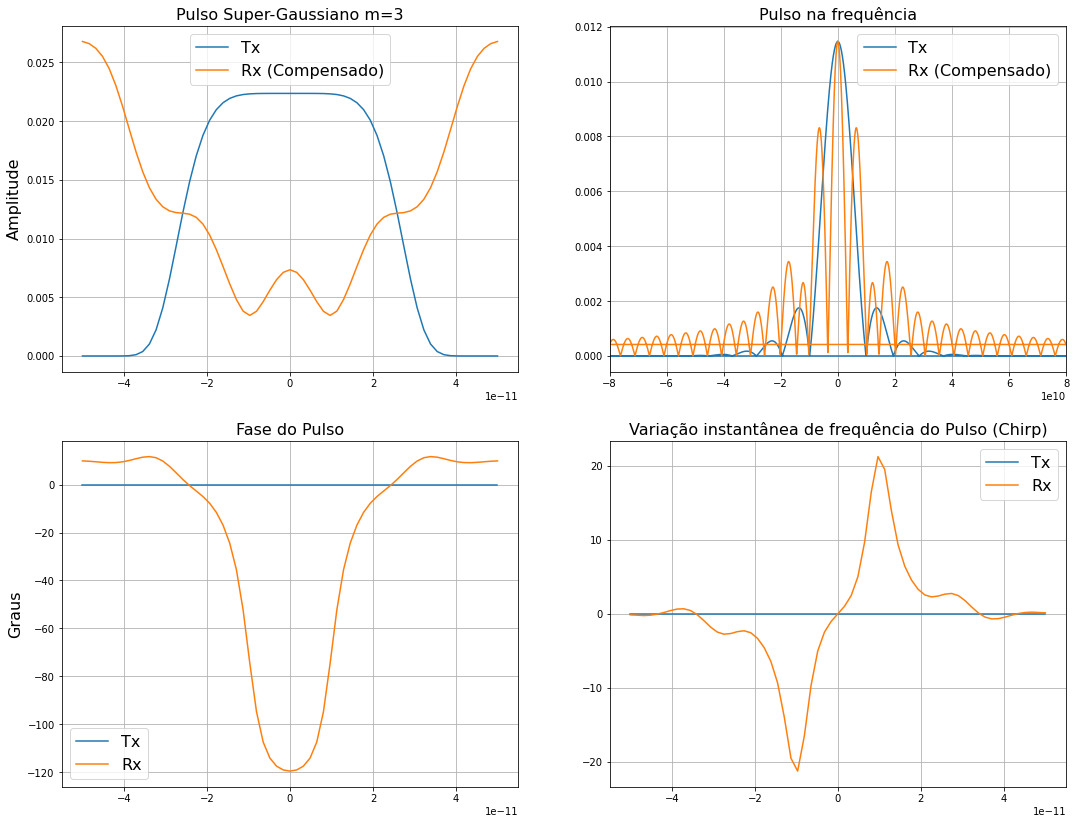

In [57]:
Pi_dBm = 0                # potência de sinal óptico na entrada do modulador em dBm
Pi = 10**(Pi_dBm/10)*1e-3  # potência de sinal óptico em W na entrada do MZM

SpSSize = 2*SpS-1
xArray = np.linspace(-Ts/2,Ts/2,SpSSize)
preSsf = supergauss(xArray, Ts/4, 0, 3)
preSsf = preSsf*np.sqrt(Pi/2)
posSsf, lent = SSF_symmetric(preSsf, StepF, z, alpha, gamma, D, c/lmbd, Fa) # Função de transferência do canal sem dispersão

#posSsf = posSsf * 10**(z*alpha*1e-4) # Compensação por escala

alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1))) # Compensação
posSsf = posSsf*np.exp(alpha_lin * lent)

figure, ax = plt.subplots(2,2,figsize=(18,14))
ax[0][0].plot(xArray,np.abs(preSsf),label='Tx')
ax[0][0].plot(xArray,np.abs(posSsf),label='Rx (Compensado)')
ax[0][0].set_title("Pulso Super-Gaussiano m=3",fontsize=16)
ax[0][0].set_ylabel("Amplitude",fontsize=16)
ax[0][0].legend(fontsize=16)
ax[0][0].grid(True)

fftSize = 2**12 # FFT Size
freq = np.fft.fftfreq(fftSize)*Fa

ax[0][1].plot(freq,np.abs(np.fft.fft(np.real(preSsf),fftSize))/len(xArray),label='Tx')
ax[0][1].plot(freq,np.abs(np.fft.fft(np.real(posSsf),fftSize))/len(xArray),label='Rx (Compensado)')
ax[0][1].set_title("Pulso na frequência",fontsize=16)
ax[0][1].legend(fontsize=16)
ax[0][1].grid(True)
ax[0][1].set_xlim(-Fa/4,Fa/4)

ax[1][0].plot(xArray,180/np.pi*np.angle(preSsf),label='Tx')
ax[1][0].plot(xArray,180/np.pi*np.angle(posSsf),label='Rx')
ax[1][0].set_title("Fase do Pulso",fontsize=16)
ax[1][0].set_ylabel("Graus",fontsize=16)
ax[1][0].legend(fontsize=16)
ax[1][0].grid(True)

ax[1][1].plot(xArray,np.gradient(180/np.pi*np.angle(preSsf),1),label='Tx')
ax[1][1].plot(xArray,np.gradient(180/np.pi*np.angle(posSsf),1),label='Rx')
ax[1][1].set_title("Variação instantânea de frequência do Pulso (Chirp)",fontsize=16)
ax[1][1].legend(fontsize=16)
ax[1][1].grid(True)

display(Math('Potência~no~modulador = %5.3f~mW~(%5.0f~dBm)'  %(Pi*1e3,Pi_dBm)))

<IPython.core.display.Math object>

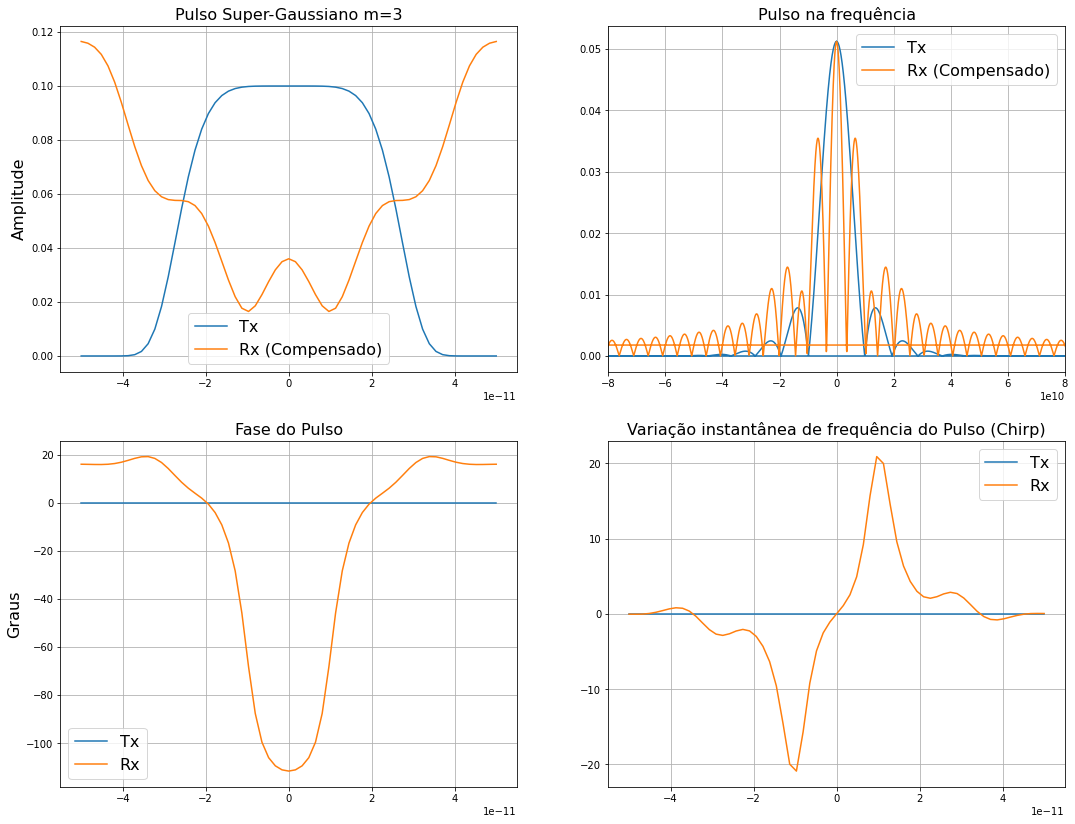

In [58]:
Pi_dBm = 13                # potência de sinal óptico na entrada do modulador em dBm
Pi = 10**(Pi_dBm/10)*1e-3  # potência de sinal óptico em W na entrada do MZM

SpSSize = 2*SpS-1
xArray = np.linspace(-Ts/2,Ts/2,SpSSize)
preSsf = supergauss(xArray, Ts/4, 0, 3)
preSsf = preSsf*np.sqrt(Pi/2)
posSsf, lent = SSF_symmetric(preSsf, StepF, z, alpha, gamma, D, c/lmbd, Fa) # Função de transferência do canal sem dispersão

#posSsf = posSsf * 10**(z*alpha*1e-4) # Compensação por escala

alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1))) # Compensação
posSsf = posSsf*np.exp(alpha_lin * lent)

figure, ax = plt.subplots(2,2,figsize=(18,14))
ax[0][0].plot(xArray,np.abs(preSsf),label='Tx')
ax[0][0].plot(xArray,np.abs(posSsf),label='Rx (Compensado)')
ax[0][0].set_title("Pulso Super-Gaussiano m=3",fontsize=16)
ax[0][0].set_ylabel("Amplitude",fontsize=16)
ax[0][0].legend(fontsize=16)
ax[0][0].grid(True)

fftSize = 2**12 # FFT Size
freq = np.fft.fftfreq(fftSize)*Fa

ax[0][1].plot(freq,np.abs(np.fft.fft(np.real(preSsf),fftSize))/len(xArray),label='Tx')
ax[0][1].plot(freq,np.abs(np.fft.fft(np.real(posSsf),fftSize))/len(xArray),label='Rx (Compensado)')
ax[0][1].set_title("Pulso na frequência",fontsize=16)
ax[0][1].legend(fontsize=16)
ax[0][1].grid(True)
ax[0][1].set_xlim(-Fa/4,Fa/4)

ax[1][0].plot(xArray,180/np.pi*np.angle(preSsf),label='Tx')
ax[1][0].plot(xArray,180/np.pi*np.angle(posSsf),label='Rx')
ax[1][0].set_title("Fase do Pulso",fontsize=16)
ax[1][0].set_ylabel("Graus",fontsize=16)
ax[1][0].legend(fontsize=16)
ax[1][0].grid(True)

ax[1][1].plot(xArray,np.gradient(180/np.pi*np.angle(preSsf),1),label='Tx')
ax[1][1].plot(xArray,np.gradient(180/np.pi*np.angle(posSsf),1),label='Rx')
ax[1][1].set_title("Variação instantânea de frequência do Pulso (Chirp)",fontsize=16)
ax[1][1].legend(fontsize=16)
ax[1][1].grid(True)

display(Math('Potência~no~modulador = %5.3f~mW~(%5.0f~dBm)'  %(Pi*1e3,Pi_dBm)))

# 10 Gbps OOK SMF28 

In [59]:
# parâmetros da simulação
SpS = 32
Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem
lmbd   = 1550e-9       # comprimento de onda
StepF  = 1000           # Passo da Split-Step Fourier (m)

# Parâmetros MZM
Vπ = 2
Vb = -Vπ/2

# Parâmetros da fibra
D = 18e-6                        # Parâmetro de dispersão ps/(nm*km) - SMF28
beta2 = -(D*lmbd**2)/(2*np.pi*c) # GVD
z = 1000e3                         # Comprimento do enlace
alpha = 0.2                      # Coeficiente de perdas dB/Km
gamma = 2*1.3e-3                   # Coeficiente Não-linear W-1/m

# Parâmetros do receptor
Rd  = 0.85      # responsividade em A/W

if(beta2==0):
    display(Math('Comprimento~de~dispersão = \\inf ~~~~~~~~~~~~~~ \\beta_{2} = %5.8f\cdot10^{-24}' %(beta2*1e24)))
else:
    LD = (Ts**2)/abs(beta2)
    display(Math('Comprimento~de~dispersão = %5.2f~m ~~~~~~~~~~~~~~ \\beta_{2} = %5.8f\cdot10^{-24}' %(LD,beta2*1e24)))
    
display(Math('Comprimento~do~enlace = %5.0f~km ~~~~~~~~~~~ \\alpha = %5.3f~dB/Km ~~~~~~~~~~~ \\gamma = %5.5f~W^{-1}/m'  %(z*1e-3,alpha,gamma)))
display(Math('Dispersão~da~fibra = %5.0f \cdot 10^{-6}~ps/(nm \cdot km) ~~~~~~~~~~~ Passo~SSF = %5.0f~m'  %(D*1e6,StepF)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

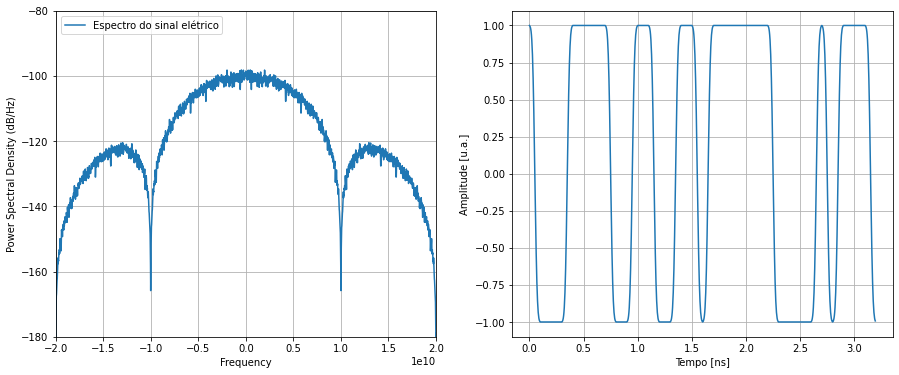

In [60]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bits-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))
# plt.figure(figsize=(10,6))
# plt.plot(np.arange(0,len(pulse)),pulse)
# print(len(pulse))
# print(pulse)

# plota sinal 
t = np.arange(0, symbTx.size)*(Ta/1e-9)

#idX = np.arange(0,513)
idX = np.arange(0,1023)

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-2*Rs,2*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], sigTx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

### Pox = 0 dBm e 1000 km

In [61]:
Pi_dBm = 0             # potência de sinal óptico na entrada do modulador em dBm
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# modulação óptica
Ai = np.sqrt(Pi)*np.ones(np.size(sigTx))
sigTxo = mzm(Ai, sigTx, Vπ, Vb)

# transmissão óptica
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))

sigRxo = sigTxo

# Fibra óptica
for i in range(10):   # 10 Iterations
    sigRxo, lent = SSF_symmetric(sigRxo, StepF, z, alpha, gamma, D, c/lmbd, Fa) # Split Step Fourier
    alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
    sigRxo    = sigRxo*np.exp(alpha_lin * lent)                                 # Compensation

# Parâmetros do compensador
NomD = -0.017                       # Dispersão nominal ps/(nm)
z2 = 1000e3                         # Comprimento a ser compensado (m)
Dcom = 1e3*NomD/z2
beta2com = -(Dcom*lmbd**2)/(2*np.pi*c) # GVD

# Compensação de dispersão
sigRxo, lent = SSF_symmetric(sigRxo, StepF, z2, alpha, gamma, Dcom, c/lmbd, Fa) # Split Step Fourier para compensar
alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
sigRxo    = sigRxo*np.exp(alpha_lin * lent)                                     # Compensation

sigRxoFFT = np.fft.fftshift(np.fft.fft(sigRxo))/NFFT
sigRxoPx  = np.abs(sigRxoFFT)**2

Potência do sinal (em dBm) = -3.01 dBm


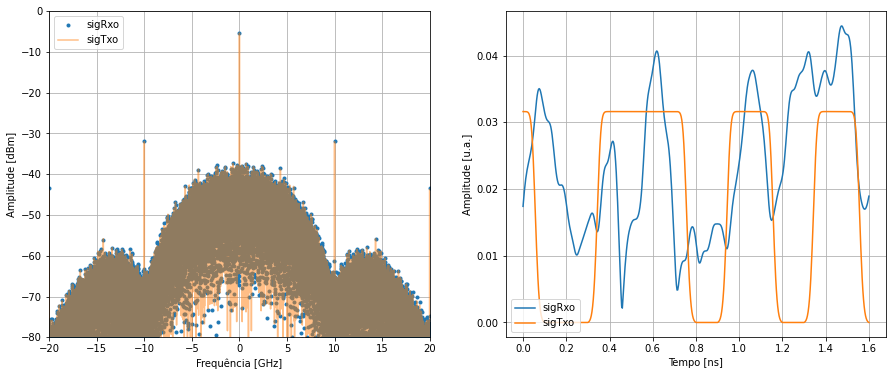

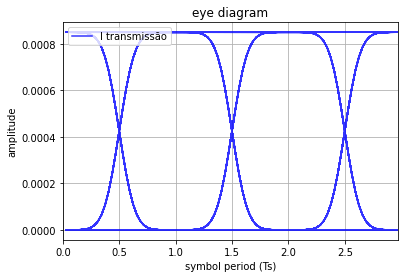

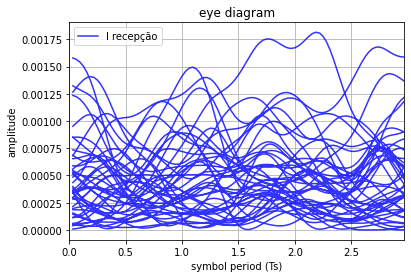

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo')
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0].set_ylabel('Amplitude [dBm]')
axs[0].set_xlabel('Frequência [GHz]')
axs[0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[0].set_ylim(-80,0)
axs[0].grid(True)
axs[0].legend(loc = 'upper left')

axs[1].plot(t[0:513], abs(sigRxo[0:513]), label = 'sigRxo')
axs[1].plot(t[0:513], abs(sigTxo[0:513]), label = 'sigTxo')
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)
axs[1].legend(loc = 'lower left')

print('Potência do sinal (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigTxoPx)/1e-3)))

# Recepção do sinal óptico
Nsamples = 2**12

# fotocorrente livre de ruído
Ip   = Rd*np.abs(sigTxo)**2
I_Rx = Rd*np.abs(sigRxo)**2

# diagrama de olho
eyediagram(Ip,  Nsamples, SpS, plotlabel='I transmissão')
eyediagram(I_Rx, Nsamples, SpS, plotlabel='I recepção')

### Pox = 10 dBm e 1000 km

In [63]:
Pi_dBm = 10             # potência de sinal óptico na entrada do modulador em dBm
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# modulação óptica
Ai = np.sqrt(Pi)*np.ones(np.size(sigTx))
sigTxo = mzm(Ai, sigTx, Vπ, Vb)

# transmissão óptica
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))

sigRxo = sigTxo

# Fibra óptica
for i in range(10):   # 10 Iterations
    sigRxo, lent = SSF_symmetric(sigRxo, StepF, z, alpha, gamma, D, c/lmbd, Fa) # Split Step Fourier
    alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
    sigRxo    = sigRxo*np.exp(alpha_lin * lent)                                 # Compensation

# Parâmetros do compensador
NomD = -0.017                       # Dispersão nominal ps/(nm)
z2 = 1000e3                         # Comprimento a ser compensado (m)
Dcom = 1e3*NomD/z2
beta2com = -(Dcom*lmbd**2)/(2*np.pi*c) # GVD

# Compensação de dispersão
sigRxo, lent = SSF_symmetric(sigRxo, StepF, z2, alpha, gamma, Dcom, c/lmbd, Fa) # Split Step Fourier para compensar
alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
sigRxo    = sigRxo*np.exp(alpha_lin * lent)                                     # Compensation

sigRxoFFT = np.fft.fftshift(np.fft.fft(sigRxo))/NFFT
sigRxoPx  = np.abs(sigRxoFFT)**2

Potência do sinal (em dBm) = 6.99 dBm


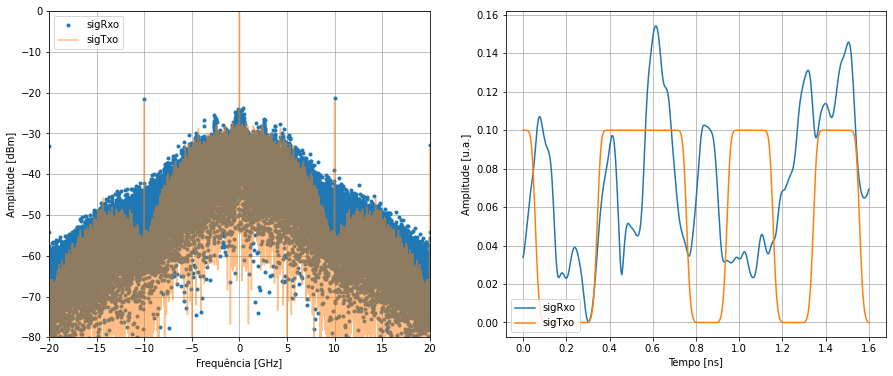

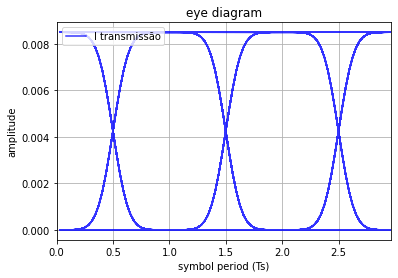

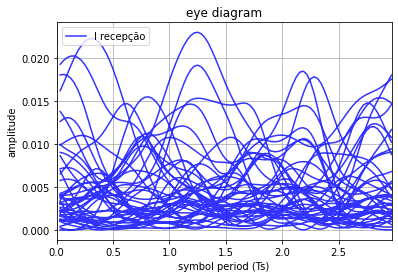

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo')
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0].set_ylabel('Amplitude [dBm]')
axs[0].set_xlabel('Frequência [GHz]')
axs[0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[0].set_ylim(-80,0)
axs[0].grid(True)
axs[0].legend(loc = 'upper left')

axs[1].plot(t[0:513], abs(sigRxo[0:513]), label = 'sigRxo')
axs[1].plot(t[0:513], abs(sigTxo[0:513]), label = 'sigTxo')
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)
axs[1].legend(loc = 'lower left')

print('Potência do sinal (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigTxoPx)/1e-3)))

# Recepção do sinal óptico
Nsamples = 2**12

# fotocorrente livre de ruído
Ip   = Rd*np.abs(sigTxo)**2
I_Rx = Rd*np.abs(sigRxo)**2

# diagrama de olho
eyediagram(Ip,  Nsamples, SpS, plotlabel='I transmissão')
eyediagram(I_Rx, Nsamples, SpS, plotlabel='I recepção')

### Pox = 13 dBm e 1000 km

In [65]:
Pi_dBm = 13             # potência de sinal óptico na entrada do modulador em dBm
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# modulação óptica
Ai = np.sqrt(Pi)*np.ones(np.size(sigTx))
sigTxo = mzm(Ai, sigTx, Vπ, Vb)

# transmissão óptica
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))

sigRxo = sigTxo

# Fibra óptica
for i in range(10):   # 10 Iterations
    sigRxo, lent = SSF_symmetric(sigRxo, StepF, z, alpha, gamma, D, c/lmbd, Fa) # Split Step Fourier
    alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
    sigRxo    = sigRxo*np.exp(alpha_lin * lent)                                 # Compensation

# Parâmetros do compensador
NomD = -0.017                       # Dispersão nominal ps/(nm)
z2 = 1000e3                         # Comprimento a ser compensado (m)
Dcom = 1e3*NomD/z2
beta2com = -(Dcom*lmbd**2)/(2*np.pi*c) # GVD

# Compensação de dispersão
sigRxo, lent = SSF_symmetric(sigRxo, StepF, z2, alpha, gamma, Dcom, c/lmbd, Fa) # Split Step Fourier para compensar
alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
sigRxo    = sigRxo*np.exp(alpha_lin * lent)                                     # Compensation

sigRxoFFT = np.fft.fftshift(np.fft.fft(sigRxo))/NFFT
sigRxoPx  = np.abs(sigRxoFFT)**2

Potência do sinal (em dBm) = 9.99 dBm


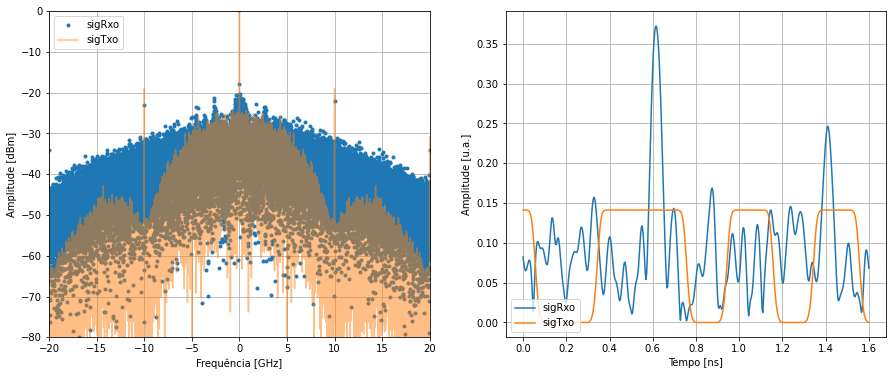

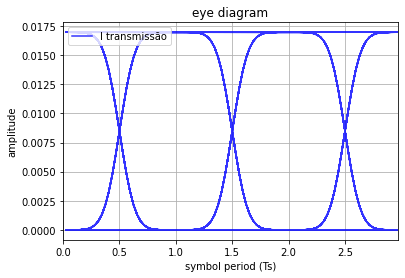

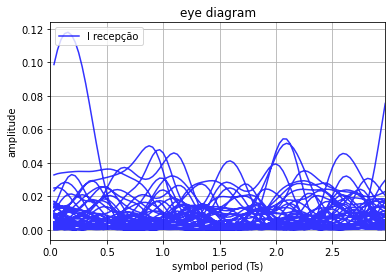

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo')
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0].set_ylabel('Amplitude [dBm]')
axs[0].set_xlabel('Frequência [GHz]')
axs[0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[0].set_ylim(-80,0)
axs[0].grid(True)
axs[0].legend(loc = 'upper left')

axs[1].plot(t[0:513], abs(sigRxo[0:513]), label = 'sigRxo')
axs[1].plot(t[0:513], abs(sigTxo[0:513]), label = 'sigTxo')
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)
axs[1].legend(loc = 'lower left')

print('Potência do sinal (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigTxoPx)/1e-3)))

# Recepção do sinal óptico
Nsamples = 2**12

# fotocorrente livre de ruído
Ip   = Rd*np.abs(sigTxo)**2
I_Rx = Rd*np.abs(sigRxo)**2

# diagrama de olho
eyediagram(Ip,  Nsamples, SpS, plotlabel='I transmissão')
eyediagram(I_Rx, Nsamples, SpS, plotlabel='I recepção')